In [1]:
# Agregamos la ruta actual como parte de las carpetas donde python busca los módulos que estamos importando (En este caso para importar el módulo de las constantes)
import sys
sys.path.append('./')

In [ ]:
# Importamos librerías necesarias
import requests # Descarga
import gzip # Descompresión de los archivos
import io # Uso de memoria temporal
import pandas as pd # Necesario para lectura de archivos
import json # Trabajar con archivos json
from tqdm import tqdm # Barra de progreso
import matplotlib.pyplot as plt # Gráficas
from collections import Counter, defaultdict # Tools
import numpy as np # Trabajo con arrays
from nltk import ngrams #N-gramas
from nltk.probability import FreqDist # Frecuencia de N-gramas
from constants import DATASETS_URL, DATASETS_FOLDER_PATH, MUESTRA_DS_PATH, DATASETS_PATH, CODIFIED_DF_PATH # Constantes
from utils import path_exists, path_concat, make_dir

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Descarga de los datos

In [3]:
#Creo un bucle que realice la descarga de cada archivo .gz y guarde solamente el .jsonl
def download_datasets(urls, output_folder_path):
    
    """
    Función para descargar los datasets
    Args:
        urls(list) = Recibe una lista de urls
        output_folder_path(string) = Ruta de la carpeta donde se almacenaran los datasets
    Returns:
        None
    """
    
    #Creo la carpeta de destino si no existe
    make_dir(output_folder_path, True)
    
    for url in urls:
        #Obtengo el nombre del dataset
        name = url.split('/')[-1][:-3]

        #Concatenamos la ruta de destino con el nombre del archivo
        dataset_path = path_concat(output_folder_path, name)
    
        #En caso de que ya tenga descargado alguno de los datasets lo salto
        if path_exists(dataset_path):
            continue
        
        #Realizo la descarga
        res = requests.get(url)
        
        #Verificamos la conexión
        if not res.ok:
            raise Exception('Ha ocurrido un error en la petición')
        
        #Cargo el archivo en memoria 
        temp_file = io.BytesIO(res.content)
        
        #Abro el archivo .gz para extraer el archivo .jsonl
        with gzip.open(temp_file, 'rt', encoding='utf-8') as tf:
            
            #Creo el archivo .jsonl y escribo los datos
            with open(dataset_path, 'w', encoding='utf-8') as f:
                f.write(tf.read())
        
        print(f"Archivo guardado en: {os.path.abspath(dataset_path)}")


In [4]:
# Verificamos si ya están descargados, en caso de que alguno lo esté, lo saltamos
if not all(path_exists(dataset) for dataset in DATASETS_PATH):
    download_datasets(DATASETS_URL, DATASETS_FOLDER_PATH)

# Análisis exploratorio de los datos

In [5]:
# Creamos una función para realizar el conteo de cuantas reviews hay en el dataset por estrellas
def contar_reviews_por_estrellas(dataset_path):
    """
    Esta función cuenta cuantas reviews tenemos por cada valoración
    Args:
        dataset_path (string): Ruta del dataset
        dataset_name (string): Nombre de dataset
    Returns:
        (dict, int): Devuelve una tupla que contiene como primer elemento un diccionario que tiene como llave la valoración y como valor el número de reviews con esa valoración y segundo elemento de la tupla es el total de registros en el dataset
    """
    # Creamos un diccionario para almacenar el conteo de reviews
    conteo = defaultdict(int)
    
    print('Contando y analizando reviews...')
    
    # Abrimos el archivo
    with open(dataset_path, 'r', encoding='utf8') as f:
        
        # Contamos cuantas lineas tenemos
        num_lines = 0
        
        # Regresamos el puntero al inicio
        f.seek(0)
        
        #Iteramos sobre cada linea
        for line in f:
            # Sumamos una línea
            num_lines += 1
            
            # Sumamos cada review
            try:
                data = json.loads(line)
                rating = data.get('rating')
                if rating is not None:
                    conteo[rating] += 1
            except json.JSONDecodeError:
                continue
        return conteo, num_lines
            

## Para realizar el proyecto voy a dividir las reviews en 3 grupos:
* **Bueno** : 4-5 Estrellas
* **Neutral** : 3 Estrellas
* **Malo** : 1-2 Estrellas


In [6]:
# Creamos una función para realizar un muestreo balanceado
def muestreo_balanceado(datasets, output_path, muestras_por_categoria):
    """
        Esta función realiza un muestreo en diferentes datasets de manera balanceada usando un enfoque probabilístico para evitar de tener sesgos en nuestra información y que sea lo más representativa posible
    Args:
        datasets (list): Ruta de los datasets a muestrear
        output_path (string): Ruta del archivo donde se almacenarán los datos tomados
        muestras_por_categoria (int): Número de muestras finales por cada categoría
    Returns:
        None
    """
    # Dividimos el número de muestras finales por cuantos datasets se van a muestrear, para así tener información balanceada
    samples = int(muestras_por_categoria / len(datasets))

    # Diccionarios con cada categoría
    categories = {
        1: "Malo", 
        2: "Malo", 
        3: "Neutral", 
        4: "Bueno", 
        5: "Bueno"
    }

    # Abrimos en modo escritura el archivo final
    with open(output_path, "w", encoding="utf8") as f:
        
        # Mediante un bucle iteramos sobre cada dataset
        for dataset in datasets:

            # Tomamos el nombre
            ds_name = dataset.split("/")[-1][:-6]

            print("Empezando muestreo balanceado en", ds_name)

            #Haciendo uso de la función contar_reviews_por_estrellas tomamos la distribución del dataset y su longitud
            conteo, num_lines = contar_reviews_por_estrellas(dataset)

            print("Distribución por estrellas: ", dict(conteo))

            # Dividimos el número de muestras en 2, y mitad para 1 y 2 para categoría malo, y mitad de 4 y 5 para la categoría bueno y en neutral lo dejamos igual
            muestras_a_tomar = {
                1: samples // 2,  # Mitad para "Malo"
                2: samples // 2,  # Mitad para "Malo"
                3: samples,       # Todas las de "Neutral"
                4: samples // 2,  # Mitad para "Bueno"
                5: samples // 2   # Mitad para "Bueno"
            }

            print("Muestras a tomar: ", muestras_a_tomar)
            
            # Abrimos en modo lectura el dataset
            with open(dataset, "r", encoding="utf8") as ds:
                
                #Iteramos sobre cada linea el dataset
                for line in tqdm(ds, total=num_lines, desc=f"Muestreando {ds_name}"):
                    
                    try:
                        # Cargamos como json cada línea
                        data = json.loads(line)
                        # Obtenemos la valoración
                        rating = data.get("rating")

                        # En caso de que la valoración NO sea de tipo int (o Nula) la saltamos
                        if rating is None or rating not in muestras_a_tomar:
                            continue
                        
                        # Si aun debemos tomar muestras de esa catearía actualizamos la probabilidad de tomar esa muestra
                        if muestras_a_tomar.get(rating, 0) > 0:
                            prob = muestras_a_tomar[rating] / conteo[rating]

                        # Tomamos un número random entre 0 a 1, y si la probabilidad de tomar esa linea es mayor, la tomamos
                        if np.random.random() < prob:
                            text = data.get('text')
                            
                            # Desde aquí vamos a categorizar cada registro
                            output_line = {
                                "category": categories[rating],  
                                "text": text
                            }
                            
                            #Lo parseamos de un obejto tipo python a tipo JSON
                            json_line = json.dumps(output_line)
                            
                            #Escribimos el registro en el archivo final
                            f.write(
                                f'{json_line}\n'
                            )
                            # Actualizamos los números para no sesgar las futuras probabilidades
                            muestras_a_tomar[rating] -= 1
                            conteo[rating] -= 1

                        # En caso de que ya hayamos terminado de tomar todas las reviews necesarias de ese dataset salimos del bucle
                        if all(x == 0 for x in muestras_a_tomar.values()):
                            break

                    except json.JSONDecodeError:
                        continue

In [7]:
# En caso de que ya exista omitimos este paso
if not path_exists(MUESTRA_DS_PATH):
    muestreo_balanceado(DATASETS_PATH, MUESTRA_DS_PATH, 100000)

In [8]:
# Leemos el archivo que hemos creado
df = pd.read_json(MUESTRA_DS_PATH, lines=True)

In [9]:
# Vamos a verificar si existe algún valor duplicado
df.duplicated().any()

True

In [10]:
# Eliminamos los duplicados
df.drop_duplicates(inplace=True)
print(f'Hay {df.duplicated().sum()} registros duplicados') if df.duplicated().any() else print('No hay registros duplicados')

No hay registros duplicados


In [11]:
# Eliminamos cualquier fila que contenga un valor nulo
df = df.dropna().reset_index(drop=True)

# Filtramos ademas donde el valor de 'text' sea un string vacío ni algo que no sea texto
df = df[df['text'].apply(lambda x: isinstance(x, str) and x.strip() != '')].reset_index(drop=True)

In [12]:
# He visto que existen ciertas reviews con rating, pero sin texto, las cuales contienen ciertas palabras comunes para indicar que no tienen contenido
# Usare el siguiente set para eliminar todos los registros así

invalid_values = {'n/a', 'na', 'null', 'none', 'nan', 'undefined', 'N/A', 'NA'}

df = df[~df['text'].str.lower().isin(invalid_values)].reset_index(drop=True)


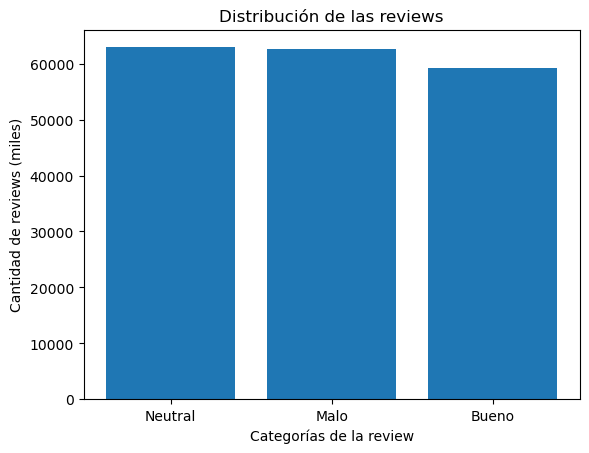

In [13]:
# Vamos a visualizar la distribución de las reviews
cat_count = df['category'].value_counts()

plt.bar(cat_count.index, cat_count.values)
plt.xlabel('Categorías de la review')
plt.ylabel('Cantidad de reviews (miles)')
plt.title('Distribución de las reviews')
plt.show()

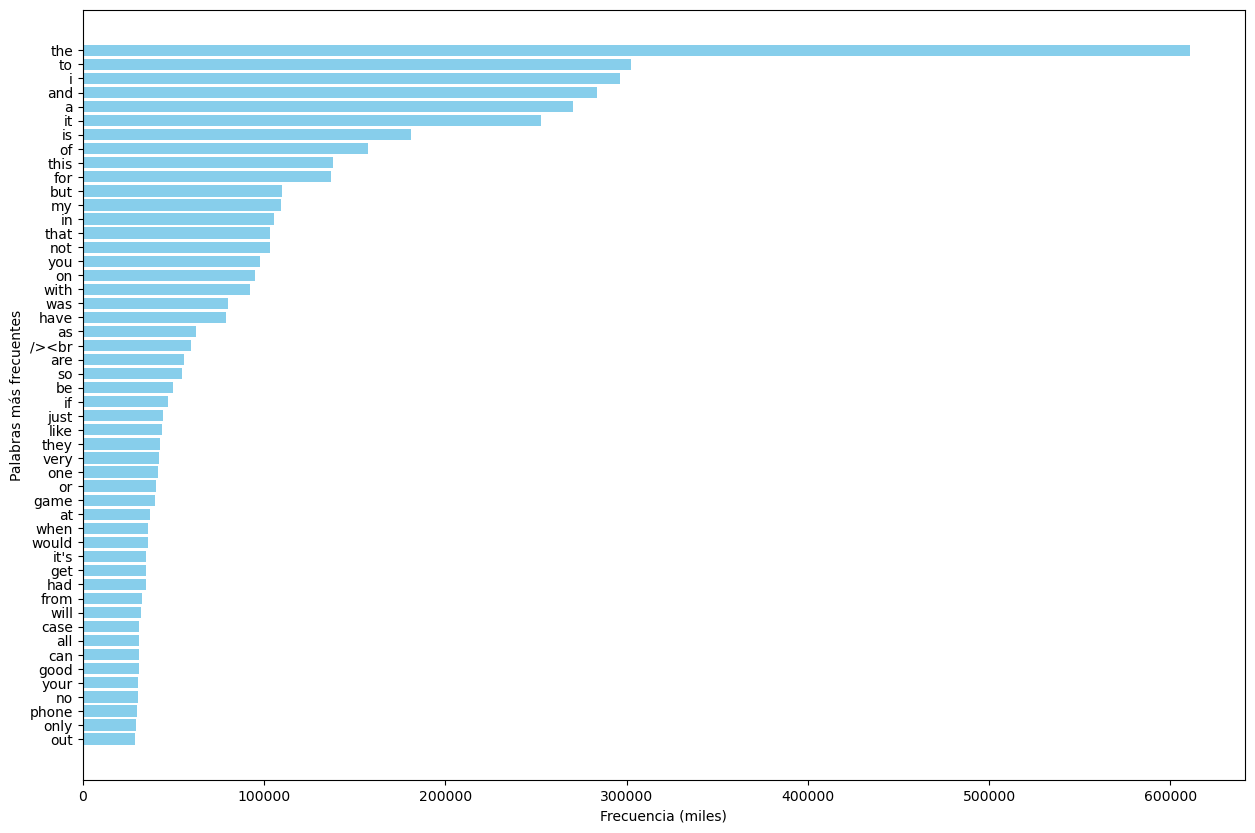

In [ ]:
# Separamos cada review por palabras
splitted_reviews = df['text'].str.lower().str.split()

# Cada review separada por palabra la convertimos en una serie y la apilamos 
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

# Contamos cuanto se repite cada palabra
word_count = Counter(words)

# Tomamos las 50 primeras
most_common_words = word_count.most_common(50)

# Las pasamos a un array
most_common_words = np.array(most_common_words)

# Ploteamos
plt.figure(figsize=(15, 10))
plt.barh(most_common_words[:, 0], most_common_words[:, 1].astype(int), color='skyblue')
plt.ylabel('Palabras más frecuentes')
plt.xlabel('Frecuencia (miles)')
plt.gca().invert_yaxis()
plt.show()

C:\Users\aleja\AppData\Local\Temp\ipykernel_9020\1450677769.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45)
C:\Users\aleja\AppData\Local\Temp\ipykernel_9020\1450677769.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=60)


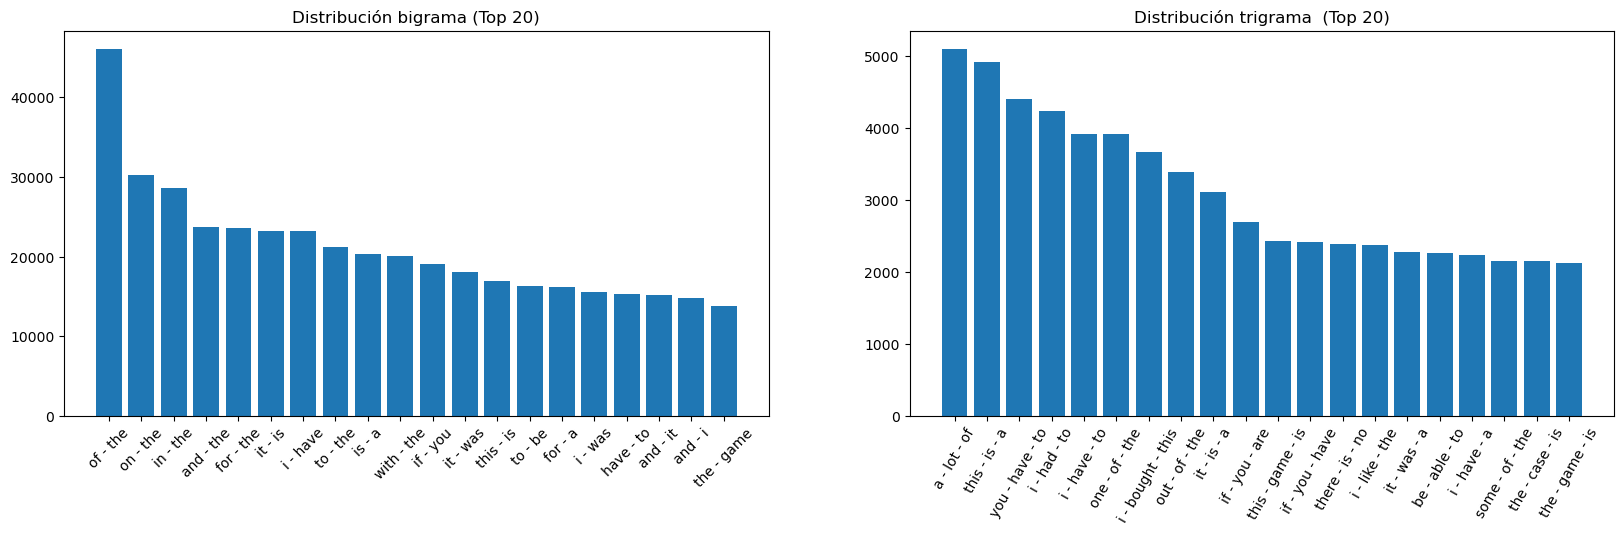

In [ ]:
# Veamos la distribución de las palabras en bigramas y trigramas

# Tomamos las frecuencias
bigrams_freq = FreqDist(ngrams(words, 2))
trigrams_freq = FreqDist(ngrams(words, 3))

# Separamos por grupo de palabras y su frecuencia
bi_labels , bi_freq = zip(*bigrams_freq.most_common(20))
tri_labels , tri_freq = zip(*trigrams_freq.most_common(20))

# Creamos la figura y ploteamos
_ , axis= plt.subplots(1, 2, figsize=(20, 5))

axis[0].set_title('Distribución bigrama (Top 20)')
axis[0].bar([f'{bi_label[0]} - {bi_label[1]}' for bi_label in bi_labels], bi_freq)
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45)

axis[1].set_title('Distribución trigrama  (Top 20)')
axis[1].bar([f'{tri_label[0]} - {tri_label[1]} - {tri_label[2]}' for tri_label in tri_labels], tri_freq)
axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=60)
plt.show()



# Codificación los sentimientos a predecir

In [15]:
# Diccionario para mapear las categorías
cat_dict = {
    "Bueno": 0,
    "Malo": 1,
    "Neutral": 2
}

# Creamos las columnas para las categorías
df['category'] = df['category'].map(cat_dict)

# Veamos como quedo 
df.head()

,category,text
0,2,love all the amazing colors but the black is r...
1,0,I really like how consistent the bright was is...
2,0,My grand niece and i are enjoying with games ...
3,1,Let me say first off that I have just unboxed ...
4,0,My kid loves this game he’s 5/6


In [17]:
# Guardamos el DF final
if not path_exists(CODIFIED_DF_PATH):
    df.to_csv(CODIFIED_DF_PATH, index=False)